In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter

In [2]:
im_x = 40
im_y = 40

seqlen = 500

In [3]:
env = Env(*[Agent(im_x, im_y) for _ in range(4)])

In [4]:
aa = env.step()

In [5]:
aa

[array([  9.48581652,  32.76250265,  16.82208338,  37.49424125]),
 array([ 13.41950436,  19.87280071,  19.2591401 ,  23.97743255]),
 array([ 18.26087299,  26.08700692,  24.53358211,  33.96984496]),
 array([ 32.91553296,  29.66841716,  38.89841512,  35.20745379])]

In [6]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/12
    vel = np.clip(vel, -1, 1)
    
    xy += vel
    
    wh += np.random.normal(size=wh.shape)/20
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.stack([wh,wh], axis=-1).reshape((-1,4))
    
    beta = []
    ds = []
    for obs in observe:
        logd = - (xyxy - obs)**2/(2*(whs/8)**2) - np.log(np.sqrt(2*np.pi)*whs)
        logd = np.sum(logd, axis=-1)
        d = np.exp(logd)
        ds.append(d)
        beta.append(d.mean())
    
    beta = np.array(beta)
    ds = np.array(ds)
    #print(beta.max())
    return np.log((beta[:,np.newaxis]*ds).sum(axis=0))

In [7]:
filters = []
aa_ = env.step()
for i in range(4):
    filt = ParticleFilter(200, 4 + 2, evol_model, observe_model, resample_2entropy=0.8)
    aa = aa_[i]
    filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*2
    filt.particles[:, 2:4] = np.clip(aa[2:4] - aa[:2] + np.random.normal(size=filt.particles[:, 2:4].shape)*0.2, 0.5, 100)
    filters.append(filt)

In [8]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append([agent.pos for agent in env.agents])
    
observe = np.array(observe)
true = np.array(true)

In [9]:
agent = env.agents[1]

In [10]:
agent.w, agent.h

(4, 6)

In [11]:
filtrated = []
for filt in filters:
    filtrated.append(filt.filtrate(observe))
filtrated = np.array(filtrated)

0.504
0.536
0.512
0.324


In [12]:
filtrated.shape

(4, 500, 200, 6)

In [13]:
filtrated = filtrated.transpose([1,2,0,3])

In [14]:
fmean = filtrated.mean(axis=1)

In [15]:
fmean.shape

(500, 4, 6)

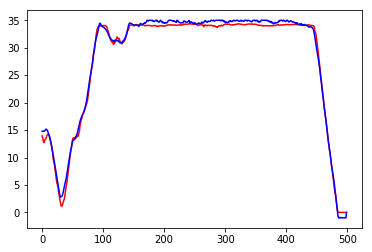

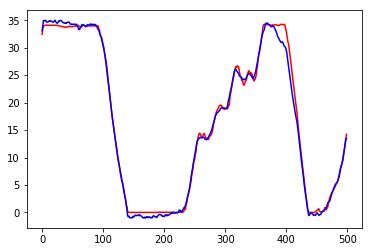

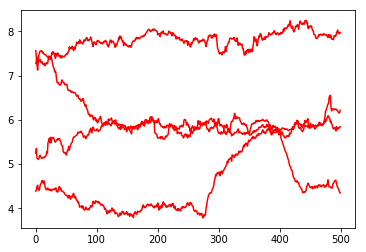

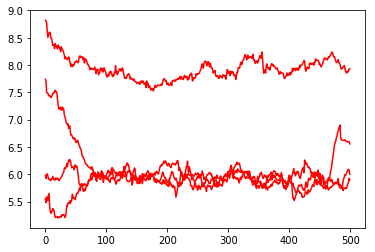

In [16]:
plt.plot(range(seqlen), fmean[:,0,0], c='r')
plt.plot(range(seqlen), true[:,0,0], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,0,1], c='r')
plt.plot(range(seqlen), true[:,0,1], c='b')
plt.show()

plt.plot(range(seqlen), fmean[:,:,2], c='r')
plt.show()

plt.plot(range(seqlen), fmean[:,:,3], c='r')
plt.show()